In [ ]:
!pip install sympy SumOfSquares qics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import scipy.integrate, scipy.linalg, scipy.optimize
from SumOfSquares import SOSProblem

The time-reversed van der Pol oscillator is governed by

$$
\begin{align*}
  \dot{x}_1 &= -x_2 ,  \\
  \dot{x}_2 &= x_1 + (x_1^2 - 1) x_2 .
\end{align*}
$$

In [2]:
def time_reversed_vanderpol_dynamics(x):
    from copy import deepcopy
    x_dot = deepcopy(x)
    x_dot[0] = -x[1]
    x_dot[1] = x[0] + (x[0]**2 - 1) * x[1]
    return x_dot

#### Helper functions

In [3]:
def vanderpol_limit_cycle():
    sol = scipy.integrate.solve_ivp(
        lambda t,x: -time_reversed_vanderpol_dynamics(x),
        t_span=[0,20],
        y0=[2.01989138,0],
        max_step=1e-2,
        events=lambda t,x: x[1]
    )
    t_start, t_end = sol.t_events[0][-3], sol.t_events[0][-1]
    mask = np.logical_and(t_start <= sol.t, sol.t <= t_end)
    x1, x2 = sol.y[0,mask], sol.y[1,mask]
    return x1, x2

def sublevel_set(U, num_points=101):
    """returns the boundary of the sublevel set where U(x1,x2) <= 1
    """
    theta = np.linspace(0, 2*np.pi, num_points)
    r = np.zeros_like(theta)
    for i in range(len(theta)-1):
        f = lambda r: U(r*np.cos(theta[i]), r*np.sin(theta[i])) - 1
        r[i] = scipy.optimize.root_scalar(f, method='bisect', bracket=[0.0,100.0]).root
    r[-1] = r[0]
    return r * np.cos(theta), r * np.sin(theta)

In [4]:
def freePolynomial(vars, degrees) -> sp.Expr:
    from itertools import combinations_with_replacement
    if not hasattr(freePolynomial, 'i'):
        freePolynomial.i = 0
    poly = sp.S(0)
    for degree in range(0, degrees+1):
        for comb in combinations_with_replacement(vars, degree):
            if degree == 0:
                comb = [sp.S(1)]
            freePolynomial.i += 1
            poly += sp.symbols(f'c_{freePolynomial.i}', real=True) * sp.prod(comb)
    return poly

def freeSymmetricMatrix(n, name) -> sp.Matrix:
    M = sp.zeros(n)
    for j in range(n):
        for i in range(j,n):
            M[i,j] = M[j,i] = sp.symbols(f'{name}_{{{i+1}{j+1}}}')
    return M

### Quadratic approximation of the region of attraction

In [5]:
x1, x2 = sp.symbols('x_1 x_2')
x = sp.Matrix([x1, x2])
x_dot = time_reversed_vanderpol_dynamics(x)

def updateMutiplizers(P):
    V = (x.T @ P).dot(x)
    V_dot = 2 * (x.T @ P).dot(x_dot)

    rho = sp.symbols(r'\rho')
    _lambda = freePolynomial([x1,x2], 0)

    prob = SOSProblem()
    prob.add_sos_constraint(x.dot(x) * (V - rho) + _lambda * V_dot, [x1,x2])
    prob.set_objective('max', prob.sym_to_var(rho))
    prob.solve(solver='qics')

    return float(prob.subs_with_sol(rho)), prob.subs_with_sol(_lambda)

def updateLyapunov(_lambda, P_old):
    P = freeSymmetricMatrix(P_old.shape[0], 'p')
    V = (x.T @ P).dot(x)
    V_dot = 2 * (x.T @ P).dot(x_dot)

    prob = SOSProblem()
    prob.add_sos_constraint(sp.expand(x.dot(x) * (V - 1) + _lambda * V_dot), [x1,x2])
    prob.add_sos_constraint(V, [x1,x2])
    prob.set_objective('max', prob.sp_to_picos(-(np.linalg.inv(P_old) * P).trace()))
    prob.solve(solver='qics')

    return np.array(prob.subs_with_sol(P), dtype=float)


A = np.mat('0 -1; 1 -1') # linearization of time_reversed_vanderpol_dynamics
P = scipy.linalg.solve_continuous_lyapunov(A.T, -np.diag([1,2])) # A.T @ P + P @ A = -diag([1 2])

V_record = []
while True:
    rho, _lambda = updateMutiplizers(P)
    P = P / rho
    print("Update rho to", rho)
    V_record.append((x.T @ P).dot(x))

    P_old = P
    P = updateLyapunov(_lambda, P_old)
    print("Update P to")
    print(P)
    V_record.append((x.T @ P).dot(x))

    if np.linalg.norm(P - P_old, np.inf) < 1e-6:
        break

Update rho to 2.2362105907658725
Update P to
[[ 0.67077737 -0.2235924 ]
 [-0.2235924   0.44718503]]
Update rho to 1.0305278242264295
Update P to
[[ 0.65090659 -0.21696885]
 [-0.21696885  0.43393781]]


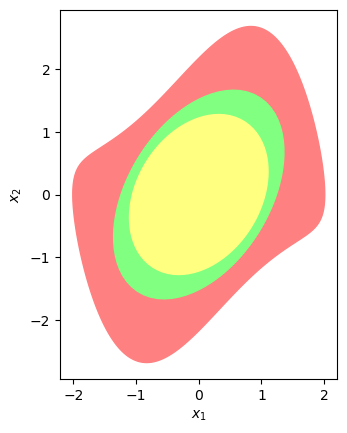

In [6]:
plt.fill(*vanderpol_limit_cycle(), color=[1,0.5,0.5])
plt.fill(*sublevel_set(sp.lambdify([x1,x2], V_record[-1])), color=[0.5,1.0,0.5])
plt.fill(*sublevel_set(sp.lambdify([x1,x2], V_record[0])),  color=[1.0,1.0,0.5])

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gca().set_aspect('equal')
plt.show()

### Quartic approximation of the region of attraction

In [ ]:
x1, x2 = sp.symbols('x_1 x_2')
x = sp.Matrix([x1, x2])
x_dot = time_reversed_vanderpol_dynamics(x)

z = sp.Matrix([x1, x2, x1**2, x2**2])
z_dot = [x_dot[0], x_dot[1], 2*x1*x_dot[0], 2*x2*x_dot[1]]

def updateMutiplizers(P):
    V = (z.T @ P).dot(z) # degree-4
    V_dot = 2 * (z.T @ P).dot(z_dot) # degree-6

    rho = sp.symbols(r'\rho')
    _lambda = freePolynomial([x1,x2], 0)

    prob = SOSProblem()
    prob.add_sos_constraint(x.dot(x) * (V - rho) + _lambda * V_dot, [x1,x2])
    prob.set_objective('max', prob.sym_to_var(rho))
    prob.solve(solver='qics')

    return float(prob.subs_with_sol(rho)), prob.subs_with_sol(_lambda)

def updateLyapunov(_lambda, P_old):
    P = freeSymmetricMatrix(P_old.shape[0], 'p')
    V = (z.T @ P).dot(z)
    V_dot = 2 * (z.T @ P).dot(z_dot)

    prob = SOSProblem()
    prob.add_sos_constraint(sp.expand(x.dot(x) * (V - 1) + _lambda * V_dot), [x1,x2])
    prob.add_sos_constraint(V, [x1,x2])
    prob.set_objective('max', prob.sp_to_picos(-(np.linalg.inv(P_old) * P).trace()))
    prob.solve(solver='qics', primals=None)
    print("Status: ", prob.status)

    return np.array(prob.subs_with_sol(P), dtype=float)


A = np.mat('0 -1; 1 -1') # linearization of time_reversed_vanderpol_dynamics
P = scipy.linalg.solve_continuous_lyapunov(A.T, -np.diag([1,2])) # A.T @ P + P @ A = -diag([1 2])
P = np.block([[P, np.zeros((2,2))], [np.zeros((2,2)), np.diag([1e-6,1e-6])]])

V_record = []
while True:
    rho, _lambda = updateMutiplizers(P)
    P = P / rho
    print("Update rho to", rho)
    V_record.append((z.T @ P).dot(z))

    P_old = P
    P = updateLyapunov(_lambda, P_old)
    print("Update P to")
    print(P)
    V_record.append((z.T @ P).dot(z))

    if np.linalg.norm(P - P_old, np.inf) < 1e-6:
        break

In [ ]:
plt.fill(*vanderpol_limit_cycle(), color=[1,0.5,0.5])
plt.fill(*sublevel_set(sp.lambdify([x1,x2], V_record[-2])),  color=[0.0,0.5,1.0])

plt.rcParams['text.usetex'] = True
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().set_aspect('equal')
# plt.savefig('fjiodlj.svg', transparent=True, bbox_inches='tight')
plt.show()